In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fftpack import fft2, ifft2
import scipy.sparse as sparse
import matplotlib.pyplot as plt


(8192, 9)
[[ 24.94003847+0.00000000e+00j  12.73268299-2.73931748e-15j
   -1.38095598-7.16736465e-15j ... -64.02389647-6.32920438e-14j
  -67.76356741-5.67289235e-14j -61.18058974-3.37964021e-14j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j


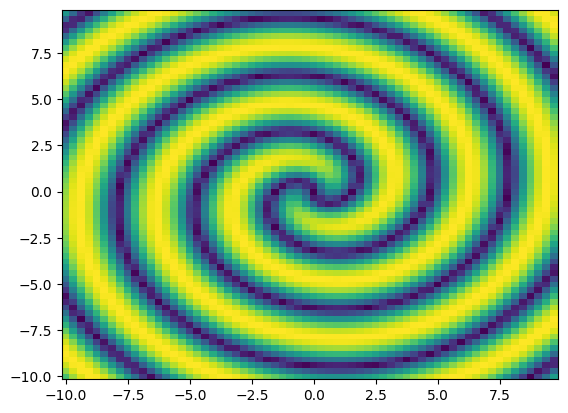

In [2]:
# Define spectral k values
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx*ny

beta = 1.0
D1 = 0.1
D2 = 0.1 
m = 1  # number of spirals

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]

# Initial conditions
X, Y = np.meshgrid(x, y)

r = np.sqrt(X**2 + Y**2)
theta = np.angle(X + 1j*Y)

u0 = np.tanh(r) * np.cos(m*theta - r)
v0 = np.tanh(r) * np.sin(m*theta - r)

u1 = fft2(u0).flatten()
v1 = fft2(v0).flatten()
y0 = np.concatenate([u1, v1])

# Time span
tspan = np.arange(0, 4 + 0.5, 0.5)

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


def diffusion_rhs(t,y,beta, D1, D2, nx, ny, N, KX, KY):

    u1 = y[:N]
    v1 = y[N:2*N]

    # Reshape input
    u1_reshape = u1.reshape(nx,ny)
    v1_reshape = v1.reshape(nx,ny)
    u = ifft2(u1_reshape)
    v = ifft2(v1_reshape)

    # Compute Laplacians
    Lapu = -(KX**2)*u1_reshape-(KY**2)*u1_reshape
    Lapv = -(KX**2)*v1_reshape-(KY**2)*v1_reshape
    
    # Defining A
    A = u**2 + v**2

    lam = (1-A)
    omega = -beta*A

    # Compute derivatives
    ut = (fft2(lam*u-omega*v)+D1*Lapu).flatten()
    vt = (fft2(omega*u+lam*v)+D2*Lapv).flatten()
    
    return np.concatenate([ut, vt])

# Solve ODE
params = (beta, D1, D2, nx, ny, N, KX, KY)
sol = solve_ivp(diffusion_rhs,t_span=[0, 4],y0=y0,t_eval=tspan,method='RK45',args=params)

# Compute A1 (final solution in Fourier domain)
A1 = sol.y

A1plot = np.abs(ifft2(A1[:N,0].reshape(nx,ny)))
plt.pcolor(x,y, A1plot)

print(A1.shape)
print(A1)


In [12]:
from scipy.linalg import kron

# Define spectral k values
Lx, Ly = 20, 20
nx, ny = 30, 30
D1 = 0.1
D2 = 0.1 

# Time span
tspan = np.arange(0, 4 + 0.5, 0.5)

# Define Cheb
def cheb(N):
    if N == 0:
        D = 0.
        x = 1.
    else:
        n = np.arange(0, N+1)
        x = np.cos(np.pi*n/N).reshape(N+1, 1)
        c = (np.hstack(([2.], np.ones(N-1), [2.])) * (-1)**n).reshape(N+1, 1)
        X = np.tile(x, (1, N+1))
        dX = X - X.T
        D = np.dot(c, 1./c.T) / (dX + np.eye(N+1))
        D -= np.diag(np.sum(D.T, axis=0))  # Changed sum() to np.sum()
    
    return D, x.reshape(N+1)

N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = (np.dot(D, D))/((Lx/2)*(Ly/2))
y = x
N2 = (N+1)*(N+1)

I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dxx, I)
print(L.shape)

X, Y = np.meshgrid(x,y)
X = X*(20/2)
Y = Y*(20/2)

m = 1
r = np.sqrt(X**2 + Y**2)
theta = np.angle(X + 1j*Y)
u0 = np.tanh(r) * np.cos(m*theta - r)
v0 = np.tanh(r) * np.sin(m*theta - r)

u1 = u0.flatten()
v1 = v0.flatten()
y0 = np.concatenate([u1, v1])

def diffusion_rhs(t,y,beta, D1, D2, N,L):

    u1 = y[:N]
    v1 = y[N:2*N]

    A = u1**2 + v1**2
    A2 = A #**2

    lam = (1-A2)
    omega = -beta*A2

    ut = lam*u1 - omega*v1 + D1*np.dot(L,u1)
    vt = omega*u1 + lam*v1 + D2*np.dot(L,v1)
    
    return np.concatenate([ut, vt])

# Solve ODE
params = (beta, D1, D2, N2,L)
sol = solve_ivp(diffusion_rhs,t_span=[0, 4],y0=y0,t_eval=tspan,method='RK45',args=params)

# Compute A1 (final solution in Fourier domain)
A2 = sol.y
print(A2.shape)
print(A2)


(961, 961)
(1922, 9)
[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


In [16]:
y0

array([0.70358468, 0.73241275, 0.81058026, ..., 0.58562756, 0.6808609 ,
       0.71061143])

In [15]:
y

array([ 1.00000000e+00,  9.94521895e-01,  9.78147601e-01,  9.51056516e-01,
        9.13545458e-01,  8.66025404e-01,  8.09016994e-01,  7.43144825e-01,
        6.69130606e-01,  5.87785252e-01,  5.00000000e-01,  4.06736643e-01,
        3.09016994e-01,  2.07911691e-01,  1.04528463e-01,  2.83276945e-16,
       -1.04528463e-01, -2.07911691e-01, -3.09016994e-01, -4.06736643e-01,
       -5.00000000e-01, -5.87785252e-01, -6.69130606e-01, -7.43144825e-01,
       -8.09016994e-01, -8.66025404e-01, -9.13545458e-01, -9.51056516e-01,
       -9.78147601e-01, -9.94521895e-01, -1.00000000e+00])